# Pb Te

In this tutorial we will setup, from scratch, a calculation of Lead Telluride (PbTe).
a thermoelectric material with a really high termoelectric efficiency.

Here, for carriying out the calculations, we will use quantum-espresso, ASE and the SSCHA for thermondynamical properties.
To setup ASE to work with espresso, please refer to the official guide:
https://wiki.fysik.dtu.dk/ase/ase/calculators/espresso.html

I prepared a CIF of the experimental structure, you can download CIF files easily from online databases,
or use ASE to build your own structure.
In this case, the structure "PbTe.cif" has been downloaded from the American Minearologist Crystal Structure Database
http://rruff.geo.arizona.edu/AMS/amcsd.php
The pseudo-potentials used for the DFT calculation are located in pseudo_espresso, a full list of pseudos is available on the espresso 
website.



## Preparation
Both ASE and the SSCHA work in python, so we need to import them.
Moreover, since we want to use quantum-espresso, we also import the Espresso calculation of ASE.
This can be replaced your favorite calculator.


In [1]:
# Load in the notebook all scientific libraries
# It can be replaced with:
# from numpy import *
# import numpy as np
# from matplotlib.pyplot import *
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
from __future__ import division
import sys,os

import ase
from ase.calculators.espresso import Espresso
from ase.visualize import view

# We import the basis modules for the SSCHA
import cellconstructor as CC
import cellconstructor.Structure
import cellconstructor.Phonons

# Import the SSCHA engine (we will use it later)
import sscha, sscha.Ensemble, sscha.SchaMinimizer, sscha.Relax

We will now setup the espresso calculator for ASE

In [12]:
# Lets define the pseudopotentials
pseudos = {"Pb": "Pb.upf",
          "Te": "Te.upf"}

# Now we define the parameters for the espresso calculations
input_params = {"ecutwfc" : 40, # The plane-wave wave-function cutoff
               "ecutrho": 160, # The density wave-function cutoff,
               "conv_thr": 1e-6, # The convergence for the DFT self-consistency
               "pseudo_dir" : "pseudo_espresso", # The directory of the pseudo potentials
               "tprnfor" : True, # Print the forces
               "tstress" : True # Print the stress tensor
               }

k_spacing = 0.2 #A^-1 The minimum distance in the Brillouin zone sampling
k_offset = (1,1,1) # Offset for the K points grid

espresso_calc = Espresso(input_data = input_params, pseudopotentials = pseudos, kspacing = k_spacing,
                        koffset = k_offset)

We need to import the structure. 

In [14]:
PbTe_atoms = ase.io.read("PbTe.cif")

# We can view the structure
view(PbTe_atoms)

As you may have noticed, this structure is in the conventional cell.
This is good for visualization purposes, but it makes calculations harder, as more atoms are present in the cell.
So we redefine the new cell unsing cellconstructor to adapt system in the primitive cell.
From an easy check on the structure, it is possible to recognize that the primitive vectors $\vec{v'}$ 
can be obtained from the conventional vectors $v$ as follows:

$$
\vec {v'}_1 = \frac 12 \left(\vec v_1 + \vec v_2\right)
$$
$$
\vec {v'}_2 = \frac 12 \left(\vec v_1 - \vec v_2\right)
$$
$$
\vec {v'}_3 = \frac 12 \left(\vec v_1 + \vec v_3\right)
$$

In [15]:
# Initialize a Cellconstructor Structure
struct = CC.Structure.Structure()
struct.generate_from_ase_atoms(PbTe_atoms)

# Define the new unit cell
new_cell = struct.unit_cell.copy()
new_cell[0,:] = .5 * struct.unit_cell[0,:] + .5*struct.unit_cell[1,:]
new_cell[1,:] = .5 * struct.unit_cell[0,:] - .5*struct.unit_cell[1,:]
new_cell[2,:] = .5 * struct.unit_cell[0,:] + .5*struct.unit_cell[2,:]

# Apply the new unit cell to the structure
# And remove duplicated atoms
struct.unit_cell = new_cell
struct.fix_coords_in_unit_cell()
PbTe_primitive = struct.get_ase_atoms()

view(PbTe_primitive)

You can see that the new unit cell is much smaller than the previous one, and we actually have only two atoms per cell, 
as we expect from a rock salt structure.

We now need to relax the cell. We can perform this operation from quantum espresso,
telling him to run a variable cell relaxation


In [ ]:
# We override (or add) the key for the calculation type
input_params["calculation"] = "vc-relax"
# Generate once again the Espresso calculator
espresso_calc = Espresso(input_data = input_params, pseudopotentials = pseudos, kspacing = k_spacing)

# We attach the calculator to the cell
PbTe_primitive.set_calculator(espresso_calc)

# We run the relaxation
equilibrium_energy = PbTe_primitive.get_total_energy() # It should take few minutes

In [10]:
# Ase should have created an input file espresso.pwi that you can check
# And redirect the output through espresso.pwo
# This relaxation should have changed the structure
# So we need to reload the structure from the output espresso file
PbTe_final= ase.io.read("espresso.pwo")

print("Volume before optimization: ", PbTe_primitive.get_volume(), " A^3")
print("Volume after optimization: ", PbTe_final.get_volume(), " A^3")

Volume before optimization:  63.71002599999998  A^3
Volume after optimization:  44.74045037391868  A^3


Now we have a structure in the primitive unit cell and relaxed.
I remark that the convergence parameters I chose for the minimization are too low to get accurate results,
especially for the variable cell relaxation.

### Harmonic calculation
Now we need to perform an harmonic calculation to get the spectra.
This can be done with perturbation theory with quantum espresso, 
or with phonopy if we want to use the finite displacement approach.

I will show a very simple PDFT espresso run.
We will compute the dynamical matrix on a 2x2x2 q mesh (equivalent of using a 2x2x2 supercell)
and we will also compute effective charges as the system is an insulator.
We will then save the results in harmonic_dyn filenames.

In [20]:
# We need an input file for phonon calculation in espresso.
ph_input = """
&inputph
    ! the final filename
    fildyn = "harmonic_dyn"
    
    ! the q mesh
    ldisp = .true.
    nq1 = 2 
    nq2 = 2
    nq3 = 2
    
    ! compute also the effective charges and the dielectric tensor
    epsil = .true.
&end
"""

# We write the input script and execute the phonon calculation program
with open("harmonic.phi", "w") as f:
    f.write(ph_input)

# Run the calculation
cmd = "/usr/bin/mpirun -np 4 ph.x -i harmonic.phi > harmonic.pho"
res = os.system(cmd) # This command took with 4 i-7 processors about 12 minutes

0

You can see that espresso generated several files:
harmonic_dyn0
harmonic_dyn1 ...
We will import them with CellConstructor.

We need only to know the number of total q independent points by symmetries, that is,
the total number of dynamical matrix printed by espresso (harmonic_dyn0 does not count).
In this case, it should be 3.

In [6]:
# Load the dynamical matrices just computed
harm_dyn = CC.Phonons.Phonons("harmonic_dyn", nqirr =3) # We load harmonic_dynX with X = 1,2,3

# Now we can print all the phonon frequencies
w_s, pols = harm_dyn.DiagonalizeSupercell()
# By default, the dynamical matrix is written in Ry/bohr^2, so the energy is in Ry
# To transform them in cm-1 we can use the conversion factor provided by CellConstructor
print ("\n".join(["{:.4f} cm-1".format(w * CC.Units.RY_TO_CM) for w in  w_s]))

-102.1596 cm-1
-102.1596 cm-1
-102.1596 cm-1
-102.1596 cm-1
-102.1596 cm-1
-102.1596 cm-1
-102.1596 cm-1
-102.1596 cm-1
-77.3568 cm-1
-77.3568 cm-1
-77.3568 cm-1
-77.3568 cm-1
-77.3568 cm-1
-77.3568 cm-1
-77.3568 cm-1
-77.3568 cm-1
-11.9291 cm-1
-11.9291 cm-1
-11.9291 cm-1
-11.9291 cm-1
23.9268 cm-1
23.9268 cm-1
23.9268 cm-1
41.9513 cm-1
41.9513 cm-1
41.9513 cm-1
41.9513 cm-1
68.6017 cm-1
68.6017 cm-1
68.6017 cm-1
68.6017 cm-1
68.6017 cm-1
68.6017 cm-1
103.2369 cm-1
103.2369 cm-1
103.2369 cm-1
160.6129 cm-1
160.6129 cm-1
160.6129 cm-1
160.6129 cm-1
160.6129 cm-1
160.6129 cm-1
163.3143 cm-1
163.3143 cm-1
163.3143 cm-1
177.3796 cm-1
177.3796 cm-1
177.3796 cm-1


What a mess?! many frequencies are imaginary (printed as negative).
We do not even have the acoustic frequencies at gamma equal to zero.

First thing: we need to impose the sum rule

In [7]:
harm_dyn.Symmetrize()

# Lets print again the frequencies
w_s, pols = harm_dyn.DiagonalizeSupercell()
print ("\n".join(["{:.4f} cm-1".format(w * CC.Units.RY_TO_CM) for w in  w_s]))

-102.1596 cm-1
-102.1596 cm-1
-102.1596 cm-1
-102.1596 cm-1
-102.1596 cm-1
-102.1596 cm-1
-102.1596 cm-1
-102.1596 cm-1
-77.3568 cm-1
-77.3568 cm-1
-77.3568 cm-1
-77.3568 cm-1
-77.3568 cm-1
-77.3568 cm-1
-77.3568 cm-1
-77.3568 cm-1
-11.9291 cm-1
-11.9291 cm-1
-11.9291 cm-1
-11.9291 cm-1
-0.0000 cm-1
-0.0000 cm-1
0.0000 cm-1
41.9513 cm-1
41.9513 cm-1
41.9513 cm-1
41.9513 cm-1
68.6017 cm-1
68.6017 cm-1
68.6017 cm-1
68.6017 cm-1
68.6017 cm-1
68.6017 cm-1
103.2369 cm-1
103.2369 cm-1
103.2369 cm-1
160.6129 cm-1
160.6129 cm-1
160.6129 cm-1
160.6129 cm-1
160.6129 cm-1
160.6129 cm-1
163.2740 cm-1
163.2740 cm-1
163.2740 cm-1
177.3796 cm-1
177.3796 cm-1
177.3796 cm-1


Ok, now the acoustic sum rule is correctly imposed. However we still have imaginary frequencies: why?

This is due to two reasons:
1) We chose low convergence cutoff properties, so some of them may be artifact
2) PbTe is a system with an incipient ferroelectric transition!

The system wants to distort the cell to break the symmetries, so no matter how well we converge the phonon calculations,
some imaginary frequencies will not be removed.

This means that the structure is in a saddle-point of the Born-Oppenheimer (BO) energy landscape.
However, PbTe is found in this structure even at T = 0 K experimentally.
How is this possible? It is anharmonicity and quantum zero-point motion that stabilize the structure.

Luckily, the SSCHA is made to deal with this kind of system.

Note that the presence of imaginary frequencies prevents the application of any harmonic approximation.

# The Self-Consistent Harmonic Approximation
Now we have all the ingredients to start a SSCHA calculation.
The SSCHA finds the optimal gaussian density matrix that minimizes the free energy of the system:
$$
\rho_{\mathcal R, \Upsilon}(\vec R) = \sqrt{\det(\Upsilon / 2\pi)} \exp \left[ -\frac 12 \sum_{\alpha\beta} (R_\alpha - \mathcal{R}_\alpha)\Upsilon_{\alpha\beta}(R_\beta - \mathcal{R}_\beta)\right]
$$
where $\mathcal{R}$ and $\Upsilon$ are, respectively, the average centroid position and the 
covariance matrix of the gaussian, while $\alpha,\beta=1\cdots 3N$ rum on both the atomic and the cartesian coordinates.

In the specific case, the $\rho_{\mathcal R, \Upsilon}(\vec R)$ density matrix can be represented by a positive definite dynamical matrix.
In fact, the equilibrium density matrix of any harmnic Hamiltonian is a gaussian. Our density matrix is related one to one to
an auxiliary harmonic hamiltonian $\mathcal H_{\mathcal R, \Upsilon}$.
$$
\rho_{\mathcal R, \Upsilon} \longleftrightarrow \mathcal H_{\mathcal R, \Upsilon}
$$

## Preparation of the data
First, we need to obtain a good starting point for our density matrix $\rho$.
We can use the harmonic dynamical matrix we computed on the previous step (harmnic_dyn).

There is a problem: an harmonic hamiltonian must be positive definite to generate a density matrix, 
and the PbTe harmonic hamiltonian is not.
Do not worry, the CellConstructor has a nice tool to force a dynamical matrix to be positive definite


In [8]:
# Load the dynamical matrix 
dyn = CC.Phonons.Phonons("harmonic_dyn", nqirr = 3)

# Apply the sum rule and symmetries
dyn.Symmetrize()

# Flip the imaginary frequencies into real ones
dyn.ForcePositiveDefinite()

# We can print the frequencies to show the magic:
w_s, pols = dyn.DiagonalizeSupercell()
print ("\n".join(["{:.4f} cm-1".format(w * CC.Units.RY_TO_CM) for w in  w_s]))

0.0000 cm-1
0.0000 cm-1
0.0000 cm-1
11.9291 cm-1
11.9291 cm-1
11.9291 cm-1
11.9291 cm-1
41.9513 cm-1
41.9513 cm-1
41.9513 cm-1
41.9513 cm-1
68.6017 cm-1
68.6017 cm-1
68.6017 cm-1
68.6017 cm-1
68.6017 cm-1
68.6017 cm-1
77.3568 cm-1
77.3568 cm-1
77.3568 cm-1
77.3568 cm-1
77.3568 cm-1
77.3568 cm-1
77.3568 cm-1
77.3568 cm-1
102.1596 cm-1
102.1596 cm-1
102.1596 cm-1
102.1596 cm-1
102.1596 cm-1
102.1596 cm-1
102.1596 cm-1
102.1596 cm-1
103.2369 cm-1
103.2369 cm-1
103.2369 cm-1
160.6129 cm-1
160.6129 cm-1
160.6129 cm-1
160.6129 cm-1
160.6129 cm-1
160.6129 cm-1
163.2740 cm-1
163.2740 cm-1
163.2740 cm-1
177.3796 cm-1
177.3796 cm-1
177.3796 cm-1


As you can see, we eliminated the imaginary frquencies. This is no more the harmonic dynamical matrix, however it is a good starting point for defining the density matrix $\rho_{\mathcal R, \Upsilon}(R)$.

## The stochastic approach
To solve the self-consistent harmonic approximation we use a stochastic approach: we generate random ionic configurations distributed according to $\rho_{\mathcal R, \Upsilon}$ so that we can compute the free energy as
$$
F_{\mathcal R, \Upsilon} = F[{\mathcal H}_{\mathcal R, \Upsilon}] + \left<V(R) - \mathcal V(R)\right>_{\rho_{\mathcal R, \Upsilon}}
$$

Here $F[\mathcal H_{\mathcal R, \Upsilon}]$ is the free energy of the auxiliary harmonic hamiltonian $\mathcal H_{\mathcal R, \Upsilon}$, 
$V(R)$ is the BO energy landscape, $\mathcal V(R)$ is the harmonic potential of the auxiliary hamiltonian $\mathcal H_{\mathcal R, \Upsilon}$ and $\left<\cdot\right>_{\rho_{\mathcal R, \Upsilon}}$ is the average over the $\rho_{\mathcal R, \Upsilon}$ density matrix.

So we need to generate the random ensemble.

In [9]:
# We setup an ensemble for the SSCHA at T = 100 K using the density matrix  from the dyn dynamical matrix
ensemble = sscha.Ensemble.Ensemble(dyn, T0 = 100, supercell= dyn.GetSupercell())

# We generate 10 randomly displaced structures in the supercell
ensemble.generate(N = 10) 

# We can look at one configuration to have an idea on how they look like
# Hint: try to raise the temperature to 1000 K or 2000 K if you want to see a bigger distortion on the lattice
view(ensemble.structures[0].get_ase_atoms())

/home/pione/anaconda2/lib/python2.7/site-packages/sscha/Ensemble.py:671: ComplexWarning: Casting complex values to real discards the imaginary part
  self.sscha_forces[i,:,:] = force


We need to compute the quantity $V(R)$ (the energy) and its gradient (the atomic forces) for each configuration. 

This can be done in many ways. You can do it manually:
You can save the ensemble as text files with the atomic coordinates and cell in this way and use your own scripts to copy that on a cluster, setup your DFT calculation, parse the output files and copy them back here, or you can pass to the ensemble class the ASE calculator object, and it will compute automatically energy and forces.
It is also possible to configure a cluster for a remote calculation so that the code will automatize anything.
In the following subsections I will follow all the possibilities, you can jump directly to the section you are more interested in.

### The ASE automatic calculation (local)
We start with the easiest possible thing. We already performed the calculation using ASE for the cell relaxation, we will setup it
now for a simple total energy DFT calculation, attach to our ensemble variable and compute the ensemble

In [51]:
# Lets setup the espresso calculator for ASE
# (You can substitute the following two lines with the calculator you prefer)
input_params["calculation"] = "scf" # Setup the simple DFT calculation

espresso_calc = Espresso(pseudopotentials = pseudos, input_data = input_params, kspacing = k_spacing)

# Now we use the espresso calculator to compute all the configurations
ensemble.compute_ensemble(espresso_calc)

conf 0 / 10
Rerun the job 1
Rerun the job 1
Rerun the job 1
Rerun the job 1
Rerun the job 1


ValueError: Error in the ASE calculator for more than 5 times

In [ ]:
# Now we can save the ensemble, to reload it in any later moment
ensemble.save("data_ensemble_ASE", population = 1)

### The manual calculation (local or on a cluster)
Here we print on separated text file the atomic positions and the cell.
We then need to parse with a script the ensemble to generate an input file for our favourite calculator, submit the calculation (it can be done on a cluster), and then parse the output files to obtain forces, energies and the stress tensors.


I will present an example for quantum espresso, however, you can easily implement your scripts to work with your own code.

In [10]:
# We save the ensemble as it is, before computing the forces
# The population flag allows us to save several ensembles inside the same directory
# As the SSCHA is an iterative algorithm, we may need more steps to converge,
# in this way we can save all the ensembles of the same SSCHA calculation inside the same directory
ensemble.save("data_ensemble_manual", population = 1)

Now lets have a look on what files the code created insode data_ensemble_manual.
The files we are interested in are:

    u_population1_X.dat  
    scf_population1_X.dat   
    forces_population1_X.dat   
    pressures_population1_X.dat    
    energies_supercell_population1.dat

In particular, the scf_population1_X.dat files contain the structures in the scf file format, that contains the info on the atomic position of each atom in the supercell written in alat units. The alat is a generic unit written on the first dynamical matrix used to generate the ensemble.
It is stored in ensemble.dyn.alat in Angstrom, or it is the fourth value of the dynamical matrix in the quantum espresso format (expressed in Bohr)


This is the file to parse in order to setup an input file for the total energy calculation.
the forces_population1_X.dat and pressures_population1_X.dat are empty (filled with zeros).
You must write on these files the forces on each atom and the stress tensor of the correspondint scf_population1_X.dat configuration.
Similarly, energies_supercell_population1.dat must contain all the energies of the scf_population1_X.dat ordered as the X index.

**Important:** the units must be for energies Ry, for forces Ry/bohr and for stress tensors Ry/bohr^3



In [21]:
# Ok now we will use python to to parse the ensemble and generate input files for the ab-initio run

# First of all, we must prepare a generic header for the calculation
typical_espresso_header = """
&control
    calculation = "scf"
    tstress = .true.
    tprnfor = .true.
    disk_io = "none"
    pseudo_dir = "pseudo_espresso"
&end
&system
    nat = {}
    ntyp = 2
    ibrav = 0
    ecutwfc = 40
    ecutrho = 160
&end
&electrons
    conv_thr = 1d-6
    !diagonalization = "cg"
&end

ATOMIC_SPECIES
Pb 207.2 Pb.upf
Te 127.6 Te.upf

K_POINTS automatic
1 1 1 0 0 0
""".format(ensemble.structures[0].N_atoms) 
# We extract the number of atoms form the ensemble and the celldm(1) from the dynamical matrix (it is stored in Angstrom, but espresso wants it in Bohr)
# You can also read it on the fourth value of the first data line on the first dynamical matrix file (dyn_start_popilation1_1); In the latter case, it will be already in Bohr.

# Now we need to read the scf files
# 
all_scf_files = [os.path.join("data_ensemble_manual", f) for f in os.listdir("data_ensemble_manual") if f.startswith("scf_")]

# In the previous line  I am reading all the files inside data_ensemble_manual os.listdir(data_ensemble_manual) and iterating over them (the f variable)
# I iterate only on the filenames that starts with scf_ 
# Then I join the directory name data_ensemble_manual to f. In unix it will be equal to data_ensemble_manual/scf_....
# (using os.path.join to concatenate path assure to have the correct behaviour independently on the operating system

# We will generate the input file in a new directory
if not os.path.exists("run_calculation"):
    os.mkdir("run_calculation")

for file in all_scf_files:
    # Now we are cycling on the scf_ files we found.
    # We must extract the number of the file
    # The file is the string "data_ensemble_manual/scf_population1_X.dat"
    # Therefore the X number is after the last "_" and before the "." character
    # We can split before the string file at each "_", isolate the last part "X.dat"
    # and then split it again on "." (obtaining ["X", "dat"]) and select the first element
    # then we convert the "X" string into an integer
    number = int(file.split("_")[-1].split(".")[0])
    
    # We decide the filename for the espresso input
    # We will call it run_calculation/espresso_run_X.pwi
    filename = os.path.join("run_calculation", "espresso_run_{}.pwi".format(number))
    
    # We start writing the file
    with open(filename, "w") as f:
        # We write the header
        f.write(typical_espresso_header)
        
        # Load the scf_population_X.dat file
        ff = open(file, "r")
        structure_lines = ff.readlines()
        ff.close()
        
        # Write the content on the espresso_run_X.pwi file
        # Note in the files we specify the units for both the cell and the structure [Angstrom]
        f.writelines(structure_lines)
        

The previous code will generate the input files inside a directory run_calculation for quantum espresso.
You can copy them to your cluster, submit a job, and copy back the results.
For completeness, the next cell of code will perform the calculation locally, it could require some time.
If you pass them to a supercomputer, remember to copy also the pseudos!

In [22]:
directory = "run_calculation"
# Copy the pseudo
for file in os.listdir(directory):
    # Skip anything that is not an espresso input file
    if not file.endswith(".pwi"):
        continue 
        
    outputname = file.replace(".pwi", ".pwo")
    
    total_inputname = os.path.join(directory, file)
    total_outputname = os.path.join(directory, outputname)
    
    # Run the calculation
    cmd = "/usr/bin/mpirun -np 4 pw.x -i {} > {}".format(total_inputname, total_outputname)
    print("Running: ", cmd) # On my laptop with 4 processors (i7) it takes about 1 minute for configuration
    os.system(cmd)

Running:  /usr/bin/mpirun -np 4 pw.x -i run_calculation/espresso_run_3.pwi > run_calculation/espresso_run_3.pwo
Running:  /usr/bin/mpirun -np 4 pw.x -i run_calculation/espresso_run_9.pwi > run_calculation/espresso_run_9.pwo
Running:  /usr/bin/mpirun -np 4 pw.x -i run_calculation/espresso_run_4.pwi > run_calculation/espresso_run_4.pwo
Running:  /usr/bin/mpirun -np 4 pw.x -i run_calculation/espresso_run_8.pwi > run_calculation/espresso_run_8.pwo
Running:  /usr/bin/mpirun -np 4 pw.x -i run_calculation/espresso_run_10.pwi > run_calculation/espresso_run_10.pwo
Running:  /usr/bin/mpirun -np 4 pw.x -i run_calculation/espresso_run_6.pwi > run_calculation/espresso_run_6.pwo
Running:  /usr/bin/mpirun -np 4 pw.x -i run_calculation/espresso_run_7.pwi > run_calculation/espresso_run_7.pwo
Running:  /usr/bin/mpirun -np 4 pw.x -i run_calculation/espresso_run_1.pwi > run_calculation/espresso_run_1.pwo
Running:  /usr/bin/mpirun -np 4 pw.x -i run_calculation/espresso_run_2.pwi > run_calculation/espresso_

Either we run the calculation locally or we copied in a cluster and runned there, now we have the output files
inside the directory, we need to retrive the energies, forces, and the stress tensor (if any).

As written, we must convert the energy in Ry, the forces in Ry/bohr and the stress in Ry/bohr^3.
Luckyly quantum espresso already gives these qantities in the correct units, but be carefull when using different calculators.
This problem does not arise when using ASE, as the sscha will automatically convert the ASE units to the correct one.
Now we will parse the espresso output looking for the energy, the forces and the stress

In [41]:
directory = "run_calculation"
output_filenames = [f for f in os.listdir(directory) if f.endswith(".pwo")] # We select only the output files
output_files = [os.path.join(directory, f) for f in output_filenames] # We add the directory/outpufilename to load them correctly

# We prepare the array of energies
energies = np.zeros(len(output_files)) 
for file in output_files:
    # Get the number of the configuration.
    id_number = int(file.split("_")[-1].split(".")[0]) # The same as before, we need the to extract the configuration number from the filename
    
    # Load the file
    ff = open(file, "r")
    lines = [l.strip() for l in ff.readlines()] # Read the whole file removing tailoring spaces
    ff.close()
    
    # Lets look for the energy (in espresso the first line that starts with !)
    # next is used to find only the first occurrence
    energy_line = next(l for l in lines if len(l) > 0 if l.split()[0] == "!")
    
    # Lets collect the energy (the actual number is the 5th item on the line, but python indexes start from 0)
    # note, also the id_number are saved starting from 1
    energies[id_number - 1] = float(energy_line.split()[4])
    
    # Now we can collect the force
    # We need the number of atoms
    nat_line = next( l for l in lines if len(l) > 0 if l.split()[0] == "number" and l.split()[2] == "atoms/cell" )
    nat = int(nat_line.split()[4])
    
    # Now allocate the forces and read them
    forces = np.zeros((nat, 3))
    forces_lines = [l for l in lines if len(l) > 0 if l.split()[0] == "atom"] # All the lines that starts with atom will contain a force
    for i in range(nat):
        forces[i, :] = [float(x) for x in forces_lines[i].split()[-3:]] # Get the last three number from the line containing the force
    
    # Now we can take the stress tensor
    stress = np.zeros((3,3))
    # We pick the index of the line that starts with the words total stress
    index_before_stress = next(i for i, l in enumerate(lines) if len(l) > 0 if l.split()[0] == "total" and l.split()[1] == "stress")
    # The stress tensor is located just after it
    for i in range(3):
        index = i + index_before_stress + 1
        stress[i, :] = [float(x) for x in lines[index].split()[:3]]

    # We can save the forces_population1_X.dat and pressures_population1_X.dat files
    force_file = os.path.join("data_ensemble_manual", "forces_population1_{}.dat".format(id_number))
    stress_file = os.path.join("data_ensemble_manual", "pressures_population1_{}.dat".format(id_number))
    np.savetxt(force_file, forces)
    np.savetxt(stress_file, stress)

# Now we read all the configurations, we can save the energy file
energy_file = os.path.join("data_ensemble_manual", "energies_supercell_population1.dat")
np.savetxt(energy_file, energies)

Now we have collected back the ensemble, and we can load it into the sscha once again.
This time, when we load the ensemble, we need also to specify the number of configurations

In [60]:
ensemble.load("data_ensemble_manual", population = 1, N = 10)

# The SSCHA minimization
In the previous section we initialized the starting density matrix $\rho_{\mathcal R,\Upsilon}$, 
and we generated a randomly distributed ensemble. Then we used quantum-espresso to compute the energies, forces and the stress from it.

In this section we will use the extracted ensemble to optimize the density matrix $\rho_{\mathcal R, \Upsilon}$ in order to minimize the free energy.
The minimization will continue until both we converge to a minimum, or our ensemble degradates.
Ensemble degradation occurs when our updated parameters $\mathcal R$ and $\Upsilon$ changes a lot with respect to the original value used to generate the ensemble.

In this case the $\mathcal R$ are fixed by symmetry, so our only degrees of freedom are in the $\Upsilon$ matrix.
therefore we force the system to ignore $\mathcal R$ for the minimization convergence.

Time elapsed to prepare the rho update: 0.202237129211 s
(of which to update sscha energies and forces: 0.0006 s)
(of which computing the Upsilon matrix: 0.1011 s)
Time elapsed to update weights the sscha energies, forces and displacements: 0.102830886841 s
(of which to update the weights): 0.00113582611084 s
Time elapsed to prepare the rho update: 0.180307865143 s
(of which to update sscha energies and forces: 0.0006 s)
(of which computing the Upsilon matrix: 0.1000 s)
Time elapsed to update weights the sscha energies, forces and displacements: 0.101738929749 s
(of which to update the weights): 0.00111508369446 s
 [GRADIENT] Time to prepare the gradient calculation: 0.0398519039154 s
 [GRADIENT] Time to call the fortran code: 0.00418496131897 s
 [GRADIENT] Time to get back in fourier space: 0.0334548950195 s

 # ---------------- NEW MINIMIZATION STEP --------------------
Step ka =  1
 [GRADIENT] Time to prepare the gradient calculation: 0.0318179130554 s
 [GRADIENT] Time to call the f

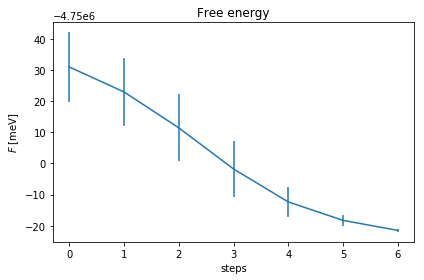

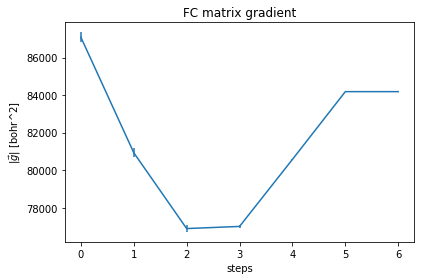

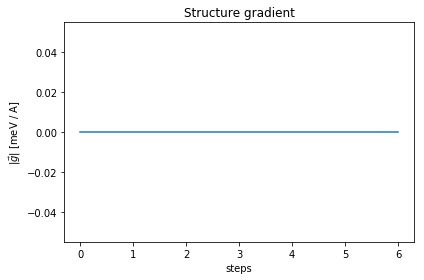

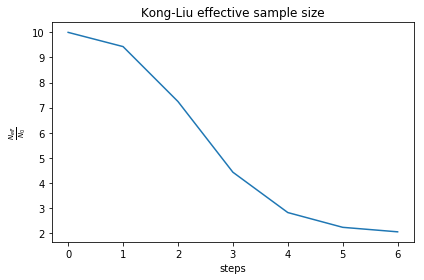

In [69]:
# Lets reset other calculation if you run this cell multiple times
ensemble.update_weights(dyn, 100) # Restore the original density matrix at T = 100 K
minimizer = sscha.SchaMinimizer.SSCHA_Minimizer(ensemble)

# Ignore the structure minimization (is fixed by symmetry)
minimizer.minim_struct = False

# Setup the minimization parameter for the covariance matrix
minimizer.min_step_dyn = 0.01 # Usually 1 is a good value

# Setup the threshold for the ensemble wasting
minimizer.kong_liu_ratio = 0.22 # Usually 0.5 is a good value

# Lest start the minimization
minimizer.init()
minimizer.run()

The privious calculation will print a lot of info on the standard output as the minimization goes.
However, after it finishes, you can plot the major features to have a hint of what happened:

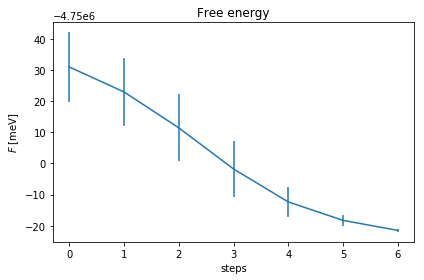

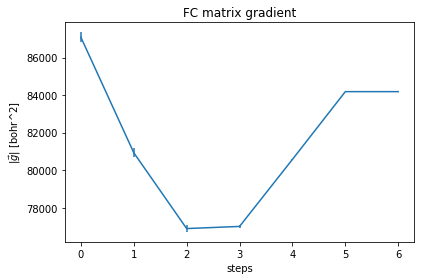

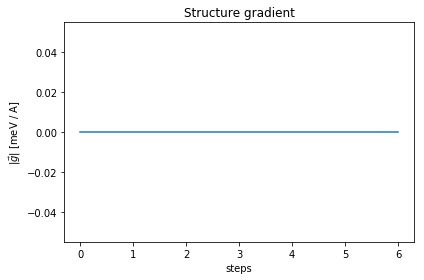

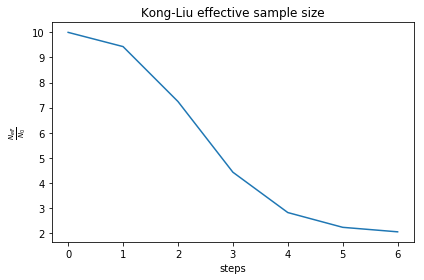

In [70]:
minimizer.plot_results()

Here you see several plots as a function of the minimization steps. 
The first one is the total Free energy (including anharmonic contributions) 
The second plot is the modulus of the free energy gradient with respect to the covariance $\Upsilon$ matrix. 
The third plot is the modulus of the free energy gradient with respect to the average atomic position $\mathcal R$.
The final plot is a measurement of the ensemble degradance.
You can notice that the gradient of the atomic position is always 0, this reflects the fact that the average position of the atoms must keep the
frequencies. 

You can also explicitly interrogate the code for quantities like Free energy and Stress tensor now that the system is ended.
To print some generic info you can use the finalize() method. Otherwise you can access to specific quantities:

In [71]:
minimizer.finalize()


 * * * * * * * * 
 *             * 
 *   RESULTS   * 
 *             * 
 * * * * * * * * 


Minimization ended after 7 steps

Free energy = -4750018.27803041 +-       1.72740447 meV
FC gradient modulus =   84183.78911110 +-       3.51314655 bohr^2
Struct gradient modulus =       0.00000000 +-       0.00000000 meV/A
Kong-Liu effective sample size =  2.2356650706036594


 ==== STRESS TENSOR [GPa] ==== 
   -194.61452598      0.00000000      0.00000000                0.01187651      0.00000000      0.00000000
      0.00000000   -194.61452598     -0.00000000    +-          0.00000000      0.01187651      0.00000000
      0.00000000     -0.00000000   -194.61452598                0.00000000      0.00000000      0.01187651

 Ab initio average stress [GPa]:
   -194.48402961      0.00000000      0.00000000
      0.00000000   -194.48402961     -0.00000000
      0.00000000      0.00000000   -194.48402961



In [80]:
print("The total free energy per unit cell is:", minimizer.get_free_energy(), " Ry")
print("The total stress tensor is [Ry/bohr^3]:")
print(minimizer.get_stress_tensor()[0])
print("And the stochastic error on the stress tensor is:")
print(minimizer.get_stress_tensor()[1])
print("The stocastic error of the free energy instead, was:", minimizer.get_free_energy(return_error = True)[1], " Ry")

The total free energy per unit cell is: -349.11977724248356  Ry
The total stress tensor is [Ry/bohr^3]:
[[-1.32296218e-02  0.00000000e+00  1.38777878e-17]
 [ 0.00000000e+00 -1.32296218e-02 -3.46944695e-18]
 [ 1.64798730e-17 -8.67361738e-19 -1.32296218e-02]]
And the stochastic error on the stress tensor is:
[[8.0734859e-07 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 8.0734859e-07 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 8.0734859e-07]]
The stocastic error of the free energy instead, was: 0.00012696184036566793  Ry
